DeePyMoD ODE Example

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
# import ..DeePyMoD.src.deepymod.training src\deepymod\training\training.py as local_training
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat
import training_adapted
# import "C:\Users\Maria\Documents\Masterstudium\Masterarbeit\Literatur\Code\DeePyMoD\src\deepymod\training\training.py" as local_training

import torch
# from torch.autograd import grad
# from itertools import combinations
# from functools import reduce
# from typing import Tuple
# from deepymod.utils.types import TensorList
# from deepymod.model.library import Library
import libraryODE

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(30)
torch.manual_seed(0)

# Configuring GPU or CPU
if False: #torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


# Preparing a new dataset
Firstly we prepare the dataset.
Therfore we load the time series (otu table) from csv file and transform it into a Dataset object.
In this example we apply DeePyMoD on the Bucci dataset from the compositional Lotka Volterra paper.

Specify the number of otu n_otu and the number of timepoints n_samples in the given dataset:

In [2]:
# n_samples = None
# n_otu = None

n_samples = 26
n_otu = 10

# specify, if not the whole dataset should be used, but only the time points up to max_samples
max_samples = n_samples

# path of data file
filename = "ts_bucci_subject_5_rel_count.csv"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/explore/data/01b-timeseries-CLVpaper/" + filename

# data should be of the form:
# [n_samples, (1 + n_otu)]
# where the first colum contains the time t

# order of interactions included in the model (2 or 3)
int_order = 2

In [3]:
def create_data():
  data = np.genfromtxt(filepath, delimiter=",")
  usol = data[1:, :] # removes header
  ts = usol[0:max_samples, 0]
  data_y = usol[0:max_samples, 1:(1 + n_otu)]
  T = torch.from_numpy(ts.reshape(-1, 1)).float()
  Y = torch.from_numpy(data_y).float()
  print("The coodinates have shape {}".format(T.shape))
  print("The data has shape {}".format(Y.shape))
  return T, Y

In [4]:
data = create_data()
print("Time:", data[0][0:10])
print("Data:", data[1][0:10])

The coodinates have shape torch.Size([26, 1])
The data has shape torch.Size([26, 10])
Time: tensor([[ 0.7500],
        [ 1.0000],
        [ 2.0000],
        [ 3.0000],
        [ 4.0000],
        [ 6.0000],
        [ 8.0000],
        [10.0000],
        [14.0000],
        [17.0000]])
Data: tensor([[6.1588e-03, 0.0000e+00, 2.0757e-02, 5.1893e-03, 2.7943e-03, 2.0244e-02,
         1.6190e-01, 4.2883e-02, 3.4786e-03, 7.7783e-02],
        [2.7145e-04, 0.0000e+00, 4.2242e-02, 7.7259e-04, 6.2642e-05, 4.3014e-02,
         8.3899e-02, 3.1739e-03, 1.6078e-03, 4.9613e-02],
        [1.9160e-03, 0.0000e+00, 2.9719e-02, 6.1950e-03, 1.5541e-03, 5.2520e-02,
         3.0532e-01, 4.0342e-02, 1.2773e-03, 8.3112e-02],
        [1.6968e-03, 0.0000e+00, 1.2287e-02, 8.1810e-04, 8.4839e-03, 3.5511e-02,
         2.7155e-01, 2.8027e-01, 8.4233e-03, 6.0766e-02],
        [1.4183e-03, 0.0000e+00, 1.9912e-02, 1.7355e-03, 1.3380e-02, 7.6251e-02,
         3.0092e-01, 2.7660e-01, 2.1666e-02, 4.4433e-02],
        [1.1191e

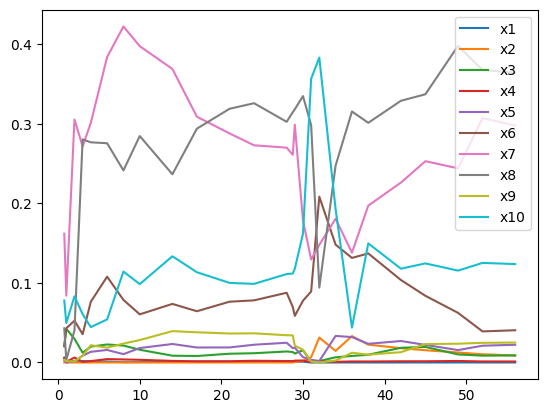

In [5]:
# plt.plot(data[0],data[1])
fig, ax = plt.subplots()
for i in np.arange(n_otu):
    ax.plot(data[0], data[1][:,i], label = f"x{i+1}")
ax.legend()

Then we pass this function to the dataset class.

In [6]:
dataset = Dataset(
    create_data,
    device = device,
)

The coodinates have shape torch.Size([26, 1])
The data has shape torch.Size([26, 10])
Dataset is using device:  cpu


Visualization of the dataset

Text(0.5, 1.0, 'Dataset')

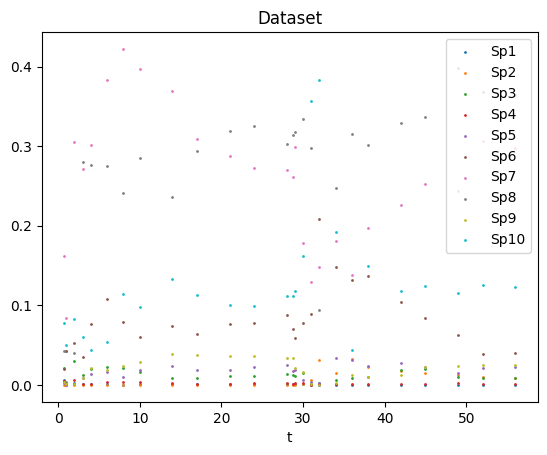

In [7]:
fig, ax = plt.subplots()
for i in np.arange(n_otu):
    ax.scatter(dataset.coords.cpu(), dataset.data[:, i].cpu(), label = f"Sp{i+1}", s=1)
ax.set_xlabel("t")
ax.legend()
ax.set_title("Dataset")
# plt.xlim([0,100])

Now we need to split our data into a train and test dataloaders for PyTorch

In [8]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [9]:
network = NN(1, [40, 40, 40, 40], n_otu)

Configuration of the library function.

In [10]:
library = libraryODE.LibraryODE(int_order = int_order, intercept = False)

Show a list of the expressions contained in the library.

In [11]:
# get a list of coefficients contained in the library
library_values = library.get_content(dataset.data)

# number of coefficients per otu
n_coefs = len(library_values[0])

# print the list
library_values

[['x1*1',
  'x1*x1',
  'x1*x2',
  'x1*x3',
  'x1*x4',
  'x1*x5',
  'x1*x6',
  'x1*x7',
  'x1*x8',
  'x1*x9',
  'x1*x10'],
 ['x2*1',
  'x2*x1',
  'x2*x2',
  'x2*x3',
  'x2*x4',
  'x2*x5',
  'x2*x6',
  'x2*x7',
  'x2*x8',
  'x2*x9',
  'x2*x10'],
 ['x3*1',
  'x3*x1',
  'x3*x2',
  'x3*x3',
  'x3*x4',
  'x3*x5',
  'x3*x6',
  'x3*x7',
  'x3*x8',
  'x3*x9',
  'x3*x10'],
 ['x4*1',
  'x4*x1',
  'x4*x2',
  'x4*x3',
  'x4*x4',
  'x4*x5',
  'x4*x6',
  'x4*x7',
  'x4*x8',
  'x4*x9',
  'x4*x10'],
 ['x5*1',
  'x5*x1',
  'x5*x2',
  'x5*x3',
  'x5*x4',
  'x5*x5',
  'x5*x6',
  'x5*x7',
  'x5*x8',
  'x5*x9',
  'x5*x10'],
 ['x6*1',
  'x6*x1',
  'x6*x2',
  'x6*x3',
  'x6*x4',
  'x6*x5',
  'x6*x6',
  'x6*x7',
  'x6*x8',
  'x6*x9',
  'x6*x10'],
 ['x7*1',
  'x7*x1',
  'x7*x2',
  'x7*x3',
  'x7*x4',
  'x7*x5',
  'x7*x6',
  'x7*x7',
  'x7*x8',
  'x7*x9',
  'x7*x10'],
 ['x8*1',
  'x8*x1',
  'x8*x2',
  'x8*x3',
  'x8*x4',
  'x8*x5',
  'x8*x6',
  'x8*x7',
  'x8*x8',
  'x8*x9',
  'x8*x10'],
 ['x9*1',
  'x9*x1',
  '

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.

In [12]:
estimator = Threshold(0.1)
sparsity_scheduler = TrainTestPeriodic(periodicity=100, patience=200, delta=1e-5)

Configuration of the sparsity estimator

In [13]:
constraint = LeastSquares()

Now we instantiate the model and select the optimizer

In [14]:
model = DeepMoD(network, library, estimator, constraint)# .to(device)

Defining optimizer

In [15]:
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=5e-3
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

 19975  MSE: 5.50e-04  Reg: 4.01e-05  L1: 2.48e+02 

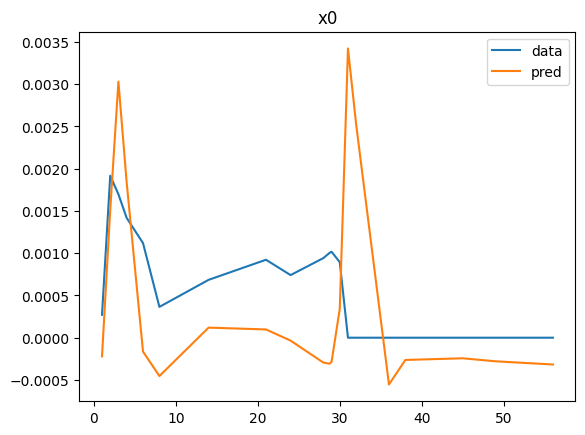

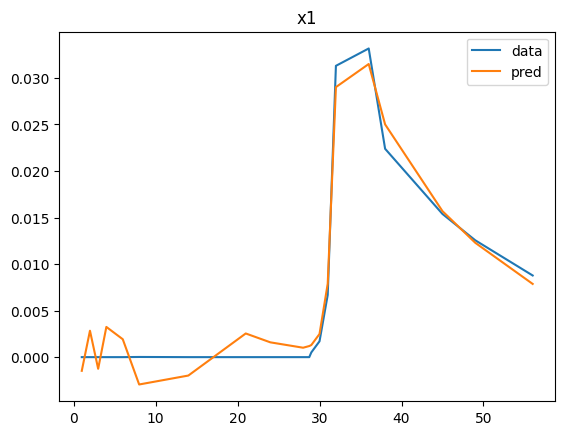

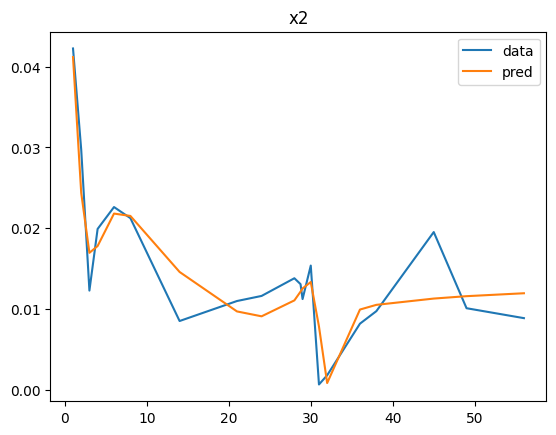

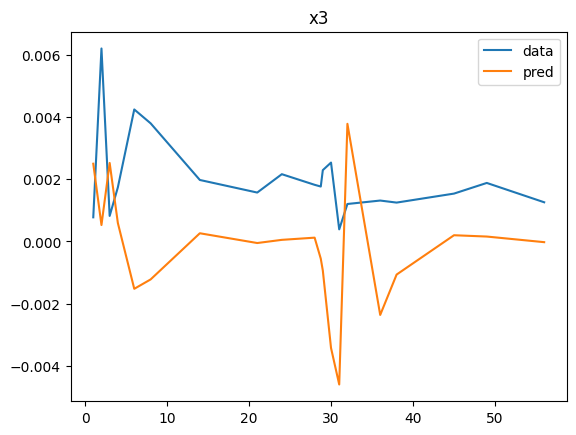

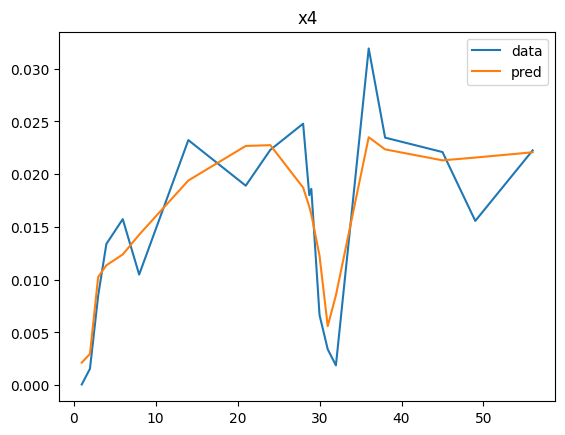

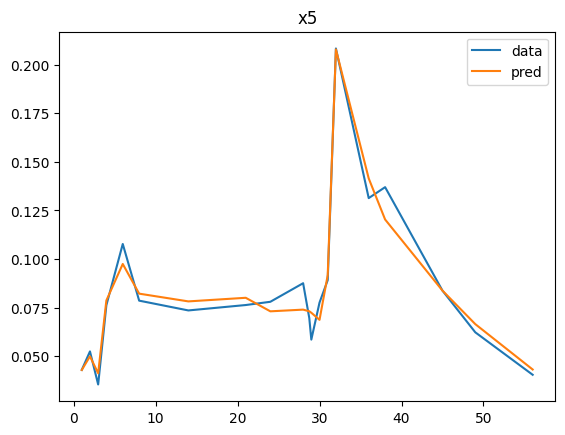

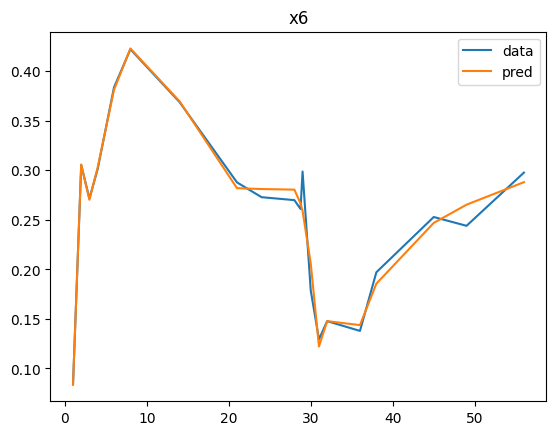

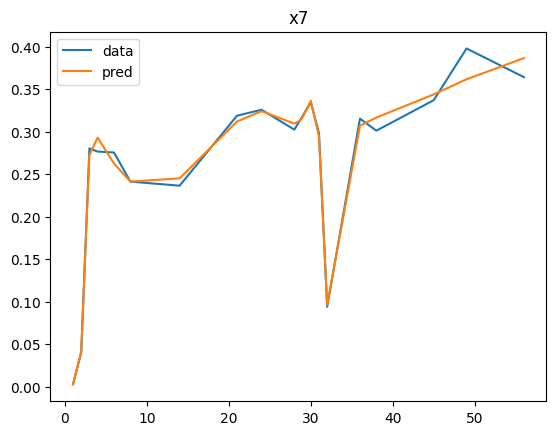

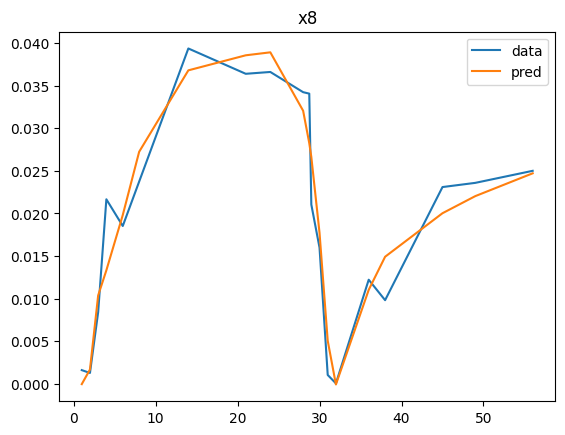

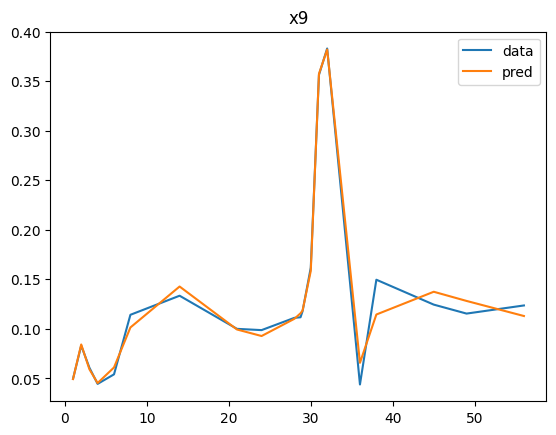

Algorithm converged. Writing model to disk.


In [16]:
training_adapted.train(
# train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    # log_dir='runs/coupled/',
    log_dir="/data/deepymod/ODE_Bucci/",
    max_iterations=50000,
    delta=1e-3,
)

Now that DeepMoD has converged, it has found the following coefficients to not be zero:

In [17]:
model.sparsity_masks

[tensor([False, False, False,  True,  True, False, False, False, False, False,
         False]),
 tensor([False,  True, False, False, False, False, False, False, False, False,
         False]),
 tensor([False, False, False, False, False, False, False, False,  True, False,
          True]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False]),
 tensor([False, False, False, False,  True, False, False, False, False, False,
         False]),
 tensor([False,  True, False, False, False, False, False, False, False, False,
         False]),
 tensor([ True, False,  True,  True, False,  True,  True,  True,  True,  True,
          True]),
 tensor([ True, False,  True,  True, False,  True,  True,  True,  True,  True,
          True]),
 tensor([ True, False,  True,  True, False,  True,  True, False,  True,  True,
          True]),
 tensor([False, False, False, False,  True, False, False, False, False, False,
         False])]

And it found the following coefficients.

In [18]:
model.estimator_coeffs()

[array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.63738984],
        [-0.6799228 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]], dtype=float32),
 array([[0.       ],
        [0.8672852],
        [0.       ],
        [0.       ],
        [0.       ],
        [0.       ],
        [0.       ],
        [0.       ],
        [0.       ],
        [0.       ],
        [0.       ]], dtype=float32),
 array([[ 0.       ],
        [ 0.       ],
        [ 0.       ],
        [ 0.       ],
        [ 0.       ],
        [ 0.       ],
        [ 0.       ],
        [ 0.       ],
        [ 1.247141 ],
        [ 0.       ],
        [-1.2444946]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.      ],
        [0.      ],
        [0. 

## Analysis/Visualization of the train() loss

In [19]:
import os
from tensorflow.python.summary.summary_iterator import summary_iterator

In [20]:
# # get list of all output values that were calculated during train()
# os.listdir("/data/deepymod/ODE_Bucci/")

In [21]:
tmp_file = os.listdir("/data/deepymod/ODE_Bucci/loss_mse_output_0/")[-1]
file_dir = "/data/deepymod/ODE_Bucci/loss_mse_output_0/" + tmp_file

train_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        train_loss = np.append(train_loss, mse)
        i += 1

# train_loss

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [22]:
tmp_file = os.listdir("/data/deepymod/ODE_Bucci/remaining_MSE_test_val_0/")[-1]
file_dir = "/data/deepymod/ODE_Bucci/remaining_MSE_test_val_0/" + tmp_file

test_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        test_loss = np.append(test_loss, mse)
        i += 1

# test_loss

In [23]:
tmp_file = os.listdir("/data/deepymod/ODE_Bucci/loss_l1_output_0/")[-1]
file_dir = "/data/deepymod/ODE_Bucci/loss_l1_output_0/" + tmp_file

l1_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        l1_loss = np.append(l1_loss, mse)
        i += 1

# l1_loss

In [24]:
tmp_file = os.listdir("/data/deepymod/ODE_Bucci/loss_reg_output_0/")[-1]
file_dir = "/data/deepymod/ODE_Bucci/loss_reg_output_0/" + tmp_file

reg_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        reg_loss = np.append(reg_loss, mse)
        i += 1

# reg_loss

(0.0, 50.0)

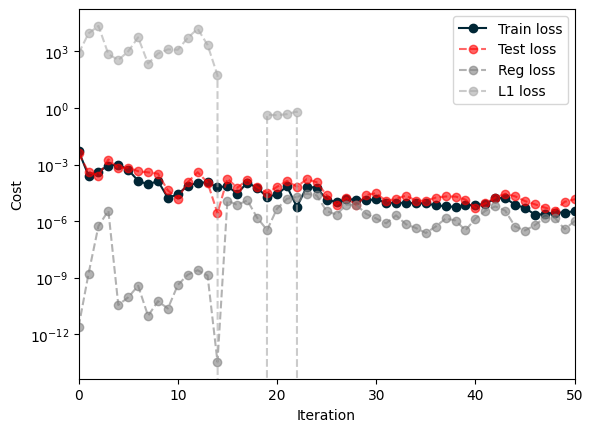

In [25]:
fig, ax = plt.subplots()
ax.plot(train_loss, c='#002635', marker='o', label='Train loss')
ax.plot(test_loss, c='red', marker='o', ls='--', alpha=0.6, label='Test loss')
ax.plot(reg_loss, c='gray', marker='o', ls='--', alpha=0.6, label='Reg loss')
ax.plot(l1_loss, c='darkgray', marker='o', ls='--', alpha=0.6, label='L1 loss')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost')
ax.legend()
plt.xlim([0, 50])

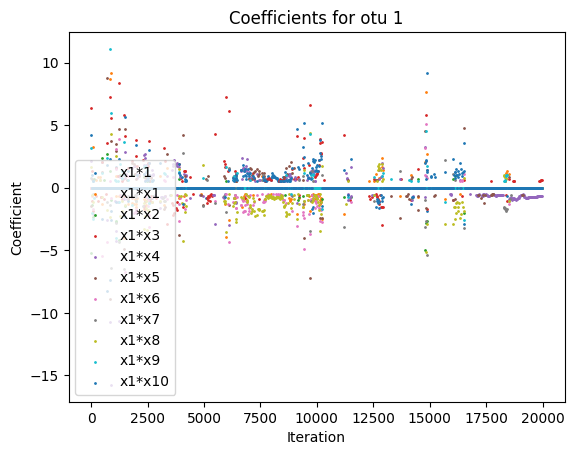

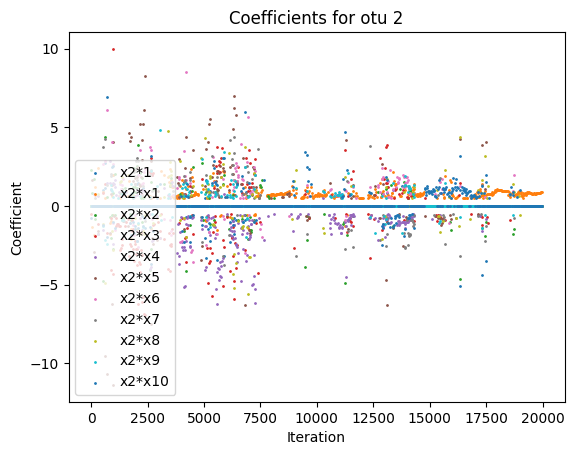

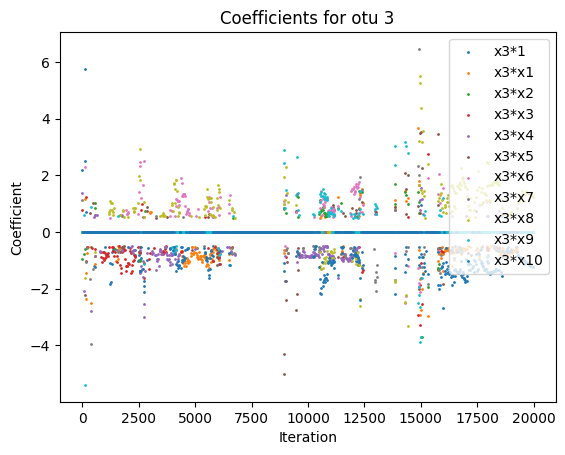

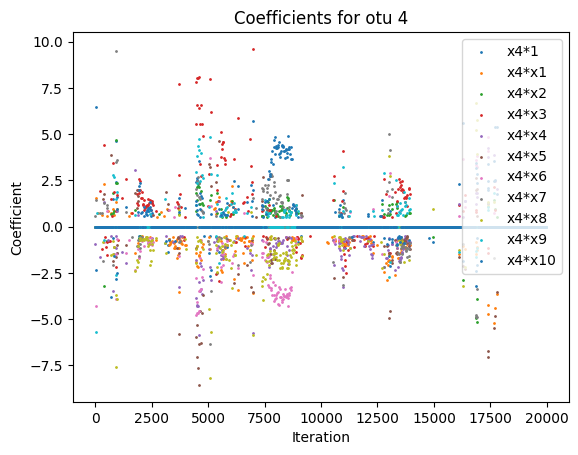

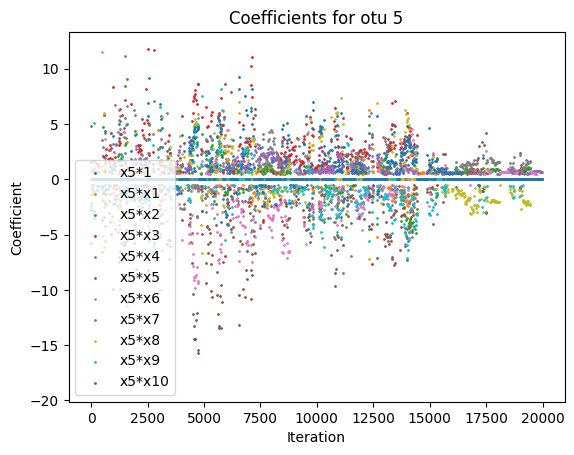

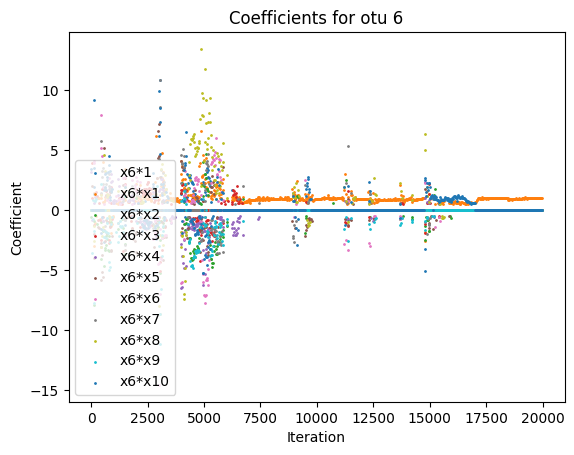

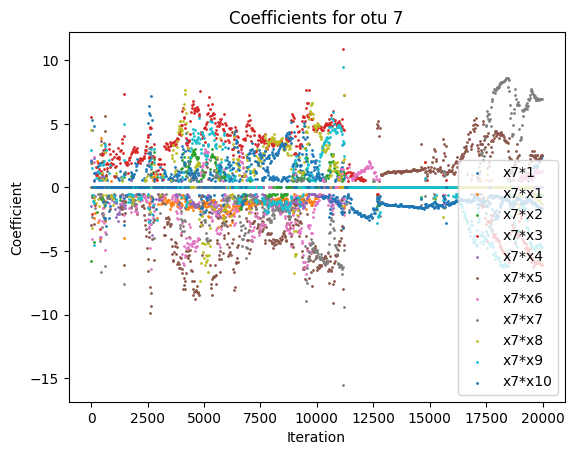

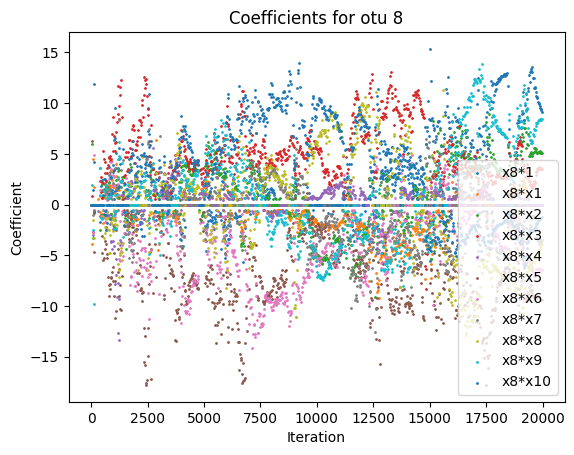

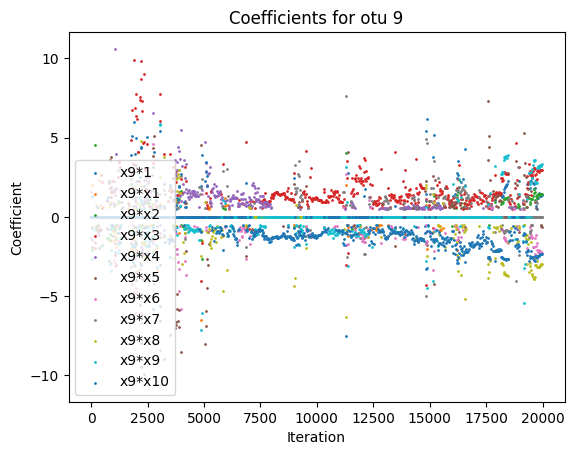

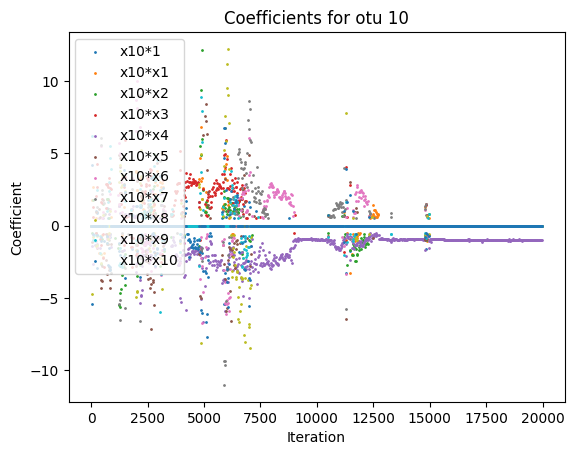

In [26]:
for otu_tmp in np.arange(n_otu):
    output = []

    for coef in np.arange(n_coefs):
        folder_dir = f"/data/deepymod/ODE_Bucci/estimator_coeffs_output_{otu_tmp}_coeff_{coef}/"
        tmp_file = os.listdir(folder_dir)[-1]
        file_dir = folder_dir + tmp_file

        output_coef = np.array([])
        i = 0
        # os.listdir(file_dir)
        for summary in summary_iterator(file_dir):
            for value in summary.summary.value:
                # Extract relevant information from the event
                coef_val = value.simple_value
                output_coef = np.append(output_coef, coef_val)
                i += 1
        output.append(output_coef)

    n_iteration = len(output[0])

    fig, ax = plt.subplots()
    for coef in np.arange(n_coefs):
        # ax.plot(output[coef], marker='o', ls='--', alpha=0.6, label=f'Coef {coef}')
        ax.scatter(np.arange(25*n_iteration, step = 25), output[coef], label = f'{library_values[otu_tmp][coef]}', s=1)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Coefficient')
    ax.set_title(f'Coefficients for otu {otu_tmp+1}')
    ax.legend()
    # plt.xlim([0, 1000])
    # plt.ylim([-50, 50])